# <span style=" font-family: Calibri" > **Measurement**

### <span style=" font-family: Calibri" > *Maya Dalton - SoDA 501 - 2/12/23*

<span style=" font-family: Calibri" > In this tutorial, I review the levels of measurement for variables, how they should be used, and provide examples of each type in application. I also discuss reclassification issues, then provide tutorials on ordinal regression and Multiple Correspondence Analysis (MCA). The data comes from the Varieties of Democracy (VDEM) dataset, Quality of Government (QoG) dataset, and the Electoral Contention and Violence (ECAV) dataset. 
    
---

## 1. Variable Types

<img src='images/levels.png' width="400" height="400">

- **Nominal**: categories with no ordering or direction, for example: *marital status (single, divorced, widowed, etc.) or type of car owned.*
- **Ordinal**: categories with ordering/ranking, for example: *lettered grading scales or the Likert scale*
- **Interval**: the distances between the intervals on the scales are the same, for example: *temperature, test scores (GRE, ACT, SAT, etc.)*
- **Ratio**: all the properties of interval variables plus a real absolute zero, for example: *money, time, and age*

In general, the amount of information increases as one goes from nominal to ratio. 

---
## 2. Examples of Each Type
Let's look at examples of each variable type, and potential issues with transforming them. The data are derived from the Electoral Contention and Violence (ECAV), Varieties of Democracy (VDEM), and Quality of Government (QoG) datasets. 

The ECAV dataset contains information on nonviolent and violent contention related to national elections from 1989-2013. These instances include events such as demonstrations, protests, riots, interpersonal violence, or killings, covering 1,208 national election rounds in 136 countries over this time period (Daxecker, Amicarelli and Jung, 2019). 

The VDEM dataset provides a multidimensional and disaggregated dataset that reflects the complexity of the concept of democracy. The dataset includes 600+ indicators annually from 1789 to the present for all countries of the world related to five high-level principles of democracy: electoral, liberal, participatory, deliberative, and egalitarian (Varieties of Democracy Project, 2023). 

Finally, the QoG dataset consists of more than 1,900 variables including (but not limited to) information on political institutions, health, environment, social policy, and poverty (Teorell, et. al. (2023). These three datasets are free to use and download. 

The variables I chose to use from each of the datasets are...
 
- **Nominal** = (Actor1Type - ECAV) Categorical variable indicating actor type in cases of electoral violence 
- **Ordinal** = (v2lgqugen - VDEM) Categorical variable indicating rankings of gender quotas based on statutory status and sanctions imposed 
- **Interval** = (v2x_polyarchy - VDEM) Electoral democracy index ranking from low to high 
- **Ratio** = (wdi_gdpcapcur - QoG) GDP per capita 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('measurement-df.csv')

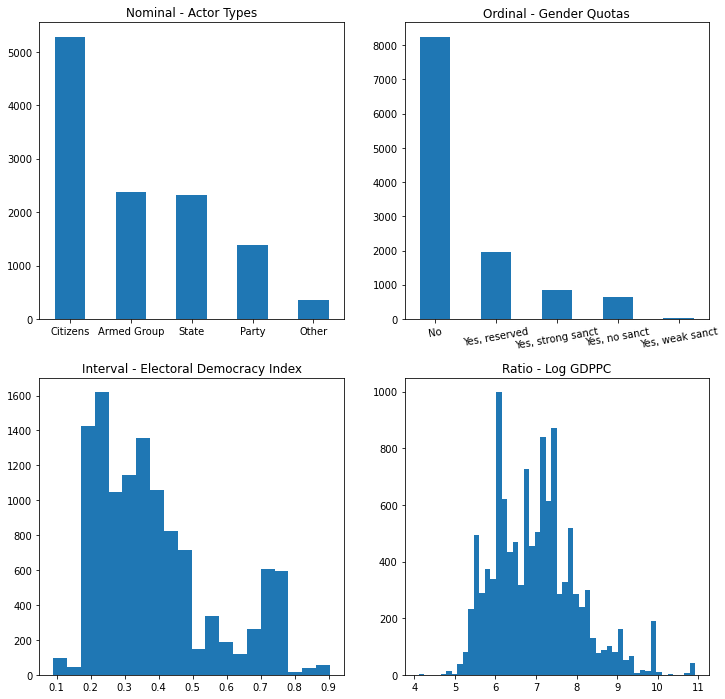

In [2]:
plt.figure(figsize=[12,12])
 
plt.subplot(221)
df['actor_ord'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel("")
plt.title('Nominal - Actor Types')
 
plt.subplot(222)
df['quota_ord'].value_counts().plot(kind='bar')
plt.xticks(rotation=10)
plt.xlabel("")
plt.title('Ordinal - Gender Quotas')
 
plt.subplot(223)
plt.hist(df['v2x_polyarchy'], bins=20)
plt.title('Interval - Electoral Democracy Index')
 
plt.subplot(224)
plt.hist(np.log(df['wdi_gdpcapcur']), bins=50)
plt.title('Ratio - Log GDPPC')
plt.show()

---
## 3. Reclassification Issues
In general, if you have interval or ratio measures you should be cautious about reclassify such measures into categories like "High" and "Low". If you do, you risk throwing away more fine-grained information. Let's look at an example of turning the Electoral Democracy Index from an interval variable to ordinal. 

In [3]:
# Define the bin edges for the ordinal categories
bin_edges = [0, 0.25, 0.5, 0.75, 1]

# Define the labels for the categories
bin_labels = ['ClosedAutocratic', 'Autocratic', 'MinimallyDemocratic', 'Democratic']

# Create a new column with the ordinal variable
df['v2x_poly_ord'] = pd.cut(df['v2x_polyarchy'], bins=bin_edges, labels=bin_labels, include_lowest=True)

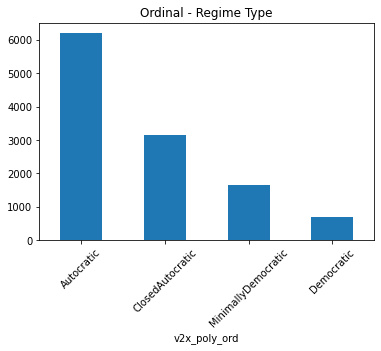

In [4]:
df['v2x_poly_ord'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Ordinal - Regime Type')
plt.show()

In the plot above, we see that a majority of the recoded variables are autocratic. Does this match the interval scale? 

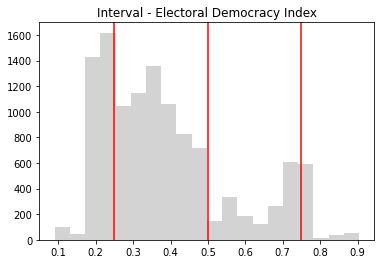

In [5]:
plt.hist(df['v2x_polyarchy'], bins=20, color='lightgrey')
plt.axvline(x = 0.25, color = 'r', label = 'axvline - full height')
plt.axvline(x = 0.5, color = 'r', label = 'axvline - full height')
plt.axvline(x = 0.75, color = 'r', label = 'axvline - full height')
plt.title('Interval - Electoral Democracy Index')
plt.show()

Looking back at the histogram of the interval scale, we see that most of the distribution falls from 0.25-0.5 which is labelled ordinally as "autocratic". So the count of the ordinal variable does match with the interval. Let's look at how the two variables differ in a linear regression model exploring how regime type influences GDP per capita. 

In [6]:
import statsmodels.api as sm

# Add a constant term to the independent variable matrix for the intercept term
X_const = sm.add_constant(df['v2x_polyarchy'])

# Fit the OLS model
model = sm.OLS(np.log(df['wdi_gdpcapcur']), X_const)
result = model.fit()

# Print the summary of the regression
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          wdi_gdpcapcur   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     459.6
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          4.79e-100
Time:                        18:42:24   Log-Likelihood:                -16745.
No. Observations:               11710   AIC:                         3.349e+04
Df Residuals:                   11708   BIC:                         3.351e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.5571      0.023    287.627

In [7]:
# Dummy encode the ordinal variable
df_encoded = pd.get_dummies(df['v2x_poly_ord'], prefix='ord')
df_encoded = df_encoded.astype(int) # convert T/F to 0/1

# Combine the encoded variables with the original dataframe
df_combined = pd.concat([df['wdi_gdpcapcur'], df_encoded], axis=1)

# Add a constant term for the intercept
X = sm.add_constant(df_combined.drop('wdi_gdpcapcur', axis=1))

# Fit the OLS model
model = sm.OLS(df_combined['wdi_gdpcapcur'], X).fit()

# Display the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          wdi_gdpcapcur   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     259.9
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          2.37e-214
Time:                        18:42:28   Log-Likelihood:            -1.1453e+05
No. Observations:               11710   AIC:                         2.291e+05
Df Residuals:                   11705   BIC:                         2.291e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

---
As you can see from the two OLS outputs above, the interval variable has a significant, positive effect on GDP per capita. Using the interval variable, as a country becomes more democratic, they have better economic conditions (although this is disputed in political science literature and outside of this basic tutorial). In the second OLS output, the results are confusing and misleading. All of the country groups have the same effect, which negative and is not statistically significant, on GDPPC. By converting an interval variable to ordinal, we lost what the original variable was actually measuring: how much a country is "electorally democratic". This shows to be cautious when reclassifying certain types of fine-grained variables (interval/ratio) into bins, as it can ruin the measurement as a whole and show very different and/or incorrect results. 

---
## 4. Ordinal Regression
Ordinal logistic regression is a model that can be used to examine the relationship between an ordinal response variable and one or more explanatory variables. We want to split our data into training and test data, using the training set for the ordinal model, and the test set for prediction/accuracy. 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.miscmodels.ordinal_model import OrderedModel

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

model = OrderedModel(train_df['v2lgqugen'], train_df[['wdi_gdpcapcur', 'v2x_polyarchy']])

result = model.fit()

# Display the model summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.903570
         Iterations: 480
         Function evaluations: 755
                             OrderedModel Results                             
Dep. Variable:              v2lgqugen   Log-Likelihood:                -8464.6
Model:                   OrderedModel   AIC:                         1.694e+04
Method:            Maximum Likelihood   BIC:                         1.698e+04
Date:                Wed, 07 Feb 2024                                         
Time:                        18:42:34                                         
No. Observations:                9368                                         
Df Residuals:                    9362                                         
Df Model:                           2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

The table above shows the results of an ordinal regression model looking at the relationship between the type of gender quota (and sanction strictness) based on GDP per capita and regime type. As a reminder, the levels of gender quotas are:

- 0: No quotas
- 1: Quotas, no sanctions
- 2: Quotas, weak sanctions
- 3: Quotas, strong sanctions
- 4: Quotas, reserved party seats

In this model, there is a coefficient for each category of gender quotas. For example, '0/1' can be interpretted as the log of odds of having no quota versus having a quota with sanctions/reserved seats. For richer and more democratic countries, they are more likely to have no quota or one with no sanction versus those with stronger sanctions or reserved seats. Each of these 'thresholds' corresponds to the log odds of being in a lower category versus the odds of being in a higher category.

In [9]:
# Make predictions on the test set
predicted_categories = result.predict(test_df[['wdi_gdpcapcur', 'v2x_polyarchy']])

# Convert predicted probabilities to predicted categories
predicted_categories = np.argmax(predicted_categories.values, axis=1)

# Evaluate the accuracy of the model
accuracy = accuracy_score(test_df['v2lgqugen'], predicted_categories)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


The accuracy is the ratio of correctly predicted instances over the total number of instances. For this model, the accuracy is 69%, means that the model correctly predicted the category for 69% of the observations in the test set and performs decently well. 

---
## 5. Multiple Correspondence Analysis (MCA)


Multiple correspondence analysis (MCA) is like principal component analysis (PCA), but for categorical data. Basically, it allows us to detect patterns in categorical data in more detail than basic regression models. Here's a basic example looking at respondents of a survey and how their responses to a number of other survey questions map onto opinions towards artificial meat. As you can see, those in favor, against, or of no opinion all group together on two latent dimensions. 

<img src='images/MCA.png' width="400" height="400">

For this part of the tutorial, I'm going to use the American National Elections Studies (ANES) 2020 pre-election survey. The variables include age, sex, political party, and a categorical variable on who the respondent voted for in the 2020 primary election. 

- V201115: How hopeful do you feel about how things are going in the country?
- V201116: How afraid do you feel about how things are going in the country?
- V201233: How often can you trust the federal government in Washington to do what is right? 
- V201325: would you say that over the past year the nation’s economy has gotten better, stayed about the same, or gotten worse?
- V201351: In the November 2020 general election, how accurately do you think the votes will be counted?
- V201354: Do you favor, oppose, or neither favor nor oppose conducting all elections by mail, instead of people voting in-person?

In [5]:
#pip install prince
import prince

In [14]:
anes = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')
anes_c = anes[['V201021', 'V201115', 'V201116', 'V201233', 'V201325', 'V201351', 'V201354']]

anes_c = anes_c.rename(columns={"V201021": "primary", "V201115": "hope", "V201116":"afraid", "V201233":"trust",
                               "V201325":"economy", "V201351":'accurate_votes', "V201354":'mail_ballots'})


anes_c = anes_c[(anes_c[anes_c.columns] > 0).all(axis=1)] #Removing NAs

# Recoding primary candidates
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = ['Biden', 'Bloomberg', 'Buttigieg', 'Klobuchar', 'Sanders', 
     'Warren', 'Other D', 'Trump', 'Other R', 'Other I']
anes_c['primary'] = anes_c['primary'].map(dict(zip(a, b)))

# Recoding hope variable
a = [1, 2, 3, 4, 5]
b = ['Not at all', 'A Little', 'Somewhat', 'Very', 'Extremely']
anes_c['hope'] = anes_c['hope'].map(dict(zip(a, b)))

# Recoding fear variable
a = [1, 2, 3, 4, 5]
b = ['Not at all', 'A Little', 'Somewhat', 'Very', 'Extremely']
anes_c['afraid'] = anes_c['afraid'].map(dict(zip(a, b)))

# Recoding fear variable
a = [1, 2, 3, 4, 5]
b = ['Not at all', 'A Little', 'Somewhat', 'Very', 'Extremely']
anes_c['trust'] = anes_c['trust'].map(dict(zip(a, b)))

# Recoding economy variable
a = [1, 2, 3]
b = ['Better', 'Same', 'Worse']
anes_c['economy'] = anes_c['economy'].map(dict(zip(a, b)))

# Recoding accurate votes variable
a = [1, 2, 3, 4, 5]
b = ['Not at all', 'A Little', 'Moderately', 'Very', 'Completely']
anes_c['accurate_votes'] = anes_c['accurate_votes'].map(dict(zip(a, b)))

# Recoding mail in ballots variable
a = [1, 2, 3]
b = ['Favor', 'Oppose', 'Neutral']
anes_c['mail_ballots'] = anes_c['mail_ballots'].map(dict(zip(a, b)))

print(anes_c)

      primary        hope      afraid      trust economy accurate_votes  \
0       Trump    Somewhat   Extremely  Extremely    Same     Moderately   
1     Other I  Not at all    Somewhat  Extremely    Same       A Little   
2      Warren  Not at all   Extremely       Very   Worse     Moderately   
4       Trump        Very        Very  Extremely   Worse       A Little   
13      Biden  Not at all   Extremely  Extremely   Worse           Very   
...       ...         ...         ...        ...     ...            ...   
8269    Biden    Somewhat        Very   Somewhat   Worse           Very   
8270    Trump    A Little  Not at all   A Little    Same     Moderately   
8271    Trump   Extremely    Somewhat   A Little    Same           Very   
8277    Biden    Somewhat    Somewhat       Very    Same           Very   
8279   Warren  Not at all        Very   Somewhat   Worse     Completely   

     mail_ballots  
0          Oppose  
1          Oppose  
2           Favor  
4          Oppose  

In [15]:
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(anes_c)

In [23]:
mca.plot(
    anes_c,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=True,
    show_row_labels=False
)

alt.LayerChart(...)

In this plot, each dot corresponds to a respondent in the ANES survey. We're mapping their vote in the 2020 primary election along with the survey questions listed above. The further labels are from the origin, the more different they are. We can think of the two dimensions here loosely coinciding with political affiliation. Those on the far right side of component 0 may be more conservative respondents, whereas those on the far left more liberal. The second dimension may recovering feelings of trust/hope/fear in the government, with the top part of the plot being stronger feelings, and towards the bottom being weaker/neutral feelings. 

Firstly, the right side of the plot coincides with those who have voted for Trump, and those that oppose mail in mallots, feel that the economy has gotten better, and are not afraid for the state of the country. We see a small bit of outliers in the top right where those that don't trust the government also feel that votes will not be counted accurately in the 2020 general election. 

On the other hand, those that voted for Biden in the primary feel like the economy has gotten worse, feel afraid for the state of our country and that the economy has gotten worse. They do have more trust in the government than expected, and favor mail in ballots. Those around Bernie Sanders felt very afaid and hopeless for the state of our country. Finally, around the middle we have most of the "neutral" feelings, such as voted for an independent, have some trust in the government and accurate votes, and believe the economy has stayed the same.

---
Hopefully this tutorial provides a good overview on types of variables, the issues with reclassification of interval variables, and two approaches to using categorical variables in your future research. 

### <span style=" font-family: Calibri" > Thank you!!